In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import functools
from multiprocessing import Pool
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load Data

flights.csv is so large, so typical pandas read csv method is slow.
By using map reduce model, a large csv file would be load in multiple chunks for speed and memory purpose

In [39]:
def make_chunks(data, num_chunks):
    chunk_size = math.ceil(len(data) / num_chunks)
    return [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]

def map_reduce(data, num_processes, mapper, reducer):
    chunks = make_chunks(data, num_processes)
    with Pool(num_processes) as pool:
        chunk_results = pool.map(mapper, chunks)
    return functools.reduce(reducer, chunk_results)

def get_counts(chunk):
    airlines = chunk["AIRLINE"]
    return airlines.str.count()

def add(previous_result, new_result):
    return previous_result.add(new_result, fill_value=0)

In [40]:
df = pd.read_csv('input/flight-delays/flights.csv', nrows=100000)
# processed_chunks = map(get_counts, chunks)
# result = functools.reduce(add, processed_chunks)

# maximums = map_reduce(values, 8, max, max)

# result = get_counts(chunks)
# print(result)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,100000.0,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,97702.000000,97702.000000,97629.000000,97629.000000,100000.000000,97387.000000,97387.000000,100000.000000,97560.000000,97560.000000,100000.000000,97560.00000,97387.000000,100000.000000,100000.000000,34625.000000,34625.000000,34625.000000,34625.000000,34625.000000
mean,2015.0,1.0,3.733920,4.107310,2240.827980,1306.348280,1326.265614,19.937749,17.155917,1348.426154,143.039340,142.362995,117.098032,830.389430,1454.528690,8.117876,1481.115620,1458.02992,18.342304,0.002240,0.023890,14.026801,0.070787,17.853921,26.014556,2.751971
std,0.0,0.0,1.815542,2.098451,1818.712658,482.325506,503.509117,45.843577,10.738373,504.142807,76.234984,76.649792,74.306645,609.183228,532.926016,7.561132,498.916358,538.21177,48.878234,0.047276,0.152707,25.965405,1.692526,43.527539,42.593343,17.265760
min,2015.0,1.0,1.000000,1.000000,1.000000,5.000000,1.000000,-39.000000,1.000000,1.000000,23.000000,17.000000,8.000000,31.000000,1.000000,1.000000,1.000000,1.00000,-65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,1.0,2.000000,2.000000,759.000000,904.000000,911.000000,-3.000000,11.000000,928.000000,86.000000,85.000000,62.000000,377.000000,1046.000000,4.000000,1100.000000,1050.00000,-8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,1.0,4.000000,4.000000,1693.000000,1300.000000,1317.000000,3.000000,14.000000,1330.000000,125.000000,125.000000,98.000000,669.000000,1452.000000,6.000000,1500.000000,1455.00000,4.000000,0.000000,0.000000,4.000000,0.000000,4.000000,10.000000,0.000000
75%,2015.0,1.0,5.000000,6.000000,3394.000000,1720.000000,1739.000000,25.000000,20.000000,1753.000000,175.000000,177.000000,150.000000,1069.000000,1907.000000,9.000000,1908.000000,1911.00000,27.000000,0.000000,0.000000,19.000000,0.000000,19.000000,35.000000,0.000000
max,2015.0,1.0,7.000000,7.000000,7438.000000,2359.000000,2400.000000,1380.000000,176.000000,2400.000000,718.000000,724.000000,676.000000,4983.000000,2400.000000,179.000000,2359.000000,2400.00000,1384.000000,1.000000,1.000000,590.000000,107.000000,1380.000000,891.000000,562.000000


## Data Cleaning

### 1. Dates and times

In the initial dataframe, dates are coded according to 4 variables: `YEAR`, `MONTH`, `DAY`, and `DAY_OF_WEEK`. In fact, python offers the `datetime` format which is really convenient to work with dates and times and I thus convert the dates in this format:


In [42]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df['DATE'].describe()

count                  100000
unique                      7
top       2015-01-02 00:00:00
freq                    16741
first     2015-01-01 00:00:00
last      2015-01-07 00:00:00
Name: DATE, dtype: object

Moreover, in the `SCHEDULED_DEPARTURE` variable, the hour of the take-off is coded as a float where the two first digits indicate the hour and the two last, the minutes. This format is not convenient and I thus convert it. Finally, I merge the take-off hour with the flight date. To proceed with these transformations, I define a few functions:

In [43]:
# Function that convert the 'HHMM' string to datetime.time
def format_hour(chain):
    if pd.isnull(chain):
        return np.nan
    else:
        if chain == 2400: chain = 0
        chain = "{0:04d}".format(int(chain))
        hour = datetime.time(int(chain[0:2]), int(chain[2:4]))
        return hour

# Function that combines a date and time to produce a datetime.datetime
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            liste.append(combine_date_hour(cols))
    return pd.Series(liste)

In [44]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hour)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hour)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hour)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


Note that in practice, the content of the `DEPARTURE_TIME` and `ARRIVAL_TIME` variables can be a bit misleading since they don't contain the dates. For exemple, in the first entry of the dataframe, the scheduled departure is at 0h05 the 1st of January. The `DEPARTURE_TIME` variable indicates 23h54 and we thus don't know if the flight leaved before time or if there was a large delay. Hence, the `DEPARTURE_DELAY` and `ARRIVAL_DELAY` variables proves more useful since they directly provides the delays in minutes. Hence, in what follows, I will not use the `DEPARTURE_TIME` and `ARRIVAL_TIME` variables.

### 2. Filling factor
Finally, I clean the dataframe throwing the variables I won't use and re-organize the columns to ease its reading:

In [45]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235,215.0


At this stage, I examine how complete the dataset is:

In [46]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,2613,97.387
1,ELAPSED_TIME,2613,97.387
2,ARRIVAL_TIME,2440,97.560
3,DEPARTURE_TIME,2298,97.702
4,DEPARTURE_DELAY,2298,97.702
5,AIRLINE,0,100.000
6,ORIGIN_AIRPORT,0,100.000
7,DESTINATION_AIRPORT,0,100.000
8,SCHEDULED_DEPARTURE,0,100.000
9,SCHEDULED_ARRIVAL,0,100.000


We see that the variables filling factor is quite good (> 97%). Since the scope of this work is not to idenfity delays pattern for possible improvement, I decide to proceed without trying to impute what's missing and I simply remove the entries that contain missing values.

In [47]:
df.dropna(inplace = True)

## Comparing airlines

As said earlier, the `AIRLINE` variable contains the airline abreviations. Their full names can be retrieved from the airlines.csv file.

In [48]:
airlines_names = pd.read_csv('input/flight-delays/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [49]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

### 2.1 Basic statistical description of airlines

As a first step, I consider all the flights from all carriers. Here, the aim is to classify the airlines with respect to their punctuality and for that purpose, I compute a few basic statisticial parameters:

In [50]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-16.0,359.0,1034.0,7.947776
HA,-13.0,830.0,1325.0,8.524528
F9,-21.0,516.0,1518.0,33.023057
NK,-23.0,557.0,1791.0,27.414852
AS,-39.0,444.0,2829.0,7.059385
B6,-24.0,500.0,4658.0,18.460069
MQ,-19.0,780.0,5415.0,33.790766
US,-20.0,362.0,6890.0,11.012046
UA,-19.0,886.0,8328.0,24.104947


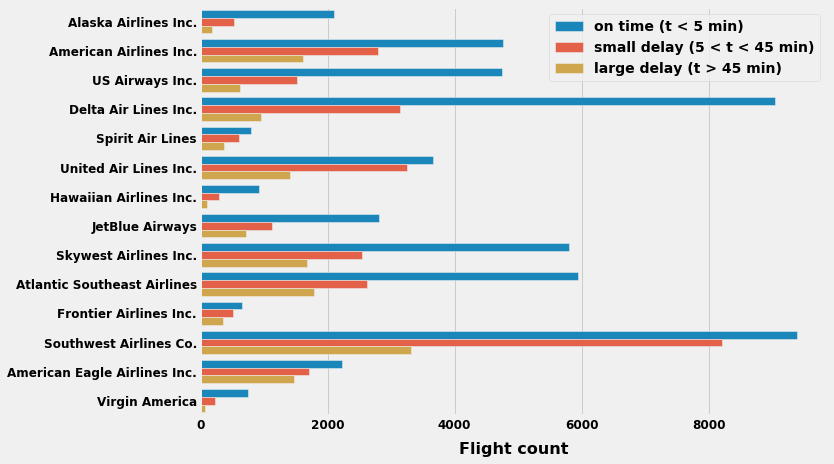

In [51]:
style.use('fivethirtyeight')
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'bold', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

This figure gives a count of the delays of less than 5 minutes, those in the range 5 < t < 45 min and finally, the delays greater than 45 minutes. Hence, we wee that independently of the airline, delays greater than 45 minutes only account for a few percents. However, the proportion of delays in these three groups depends on the airline: as an exemple, in the case of United Airlines, the delays greater than 45 minutes are 2 times less frequent than delays in the range 5 < t < 45 min. Things are better for Southwest Airlines since delays greater than 45 minutes are 3 times less frequent than delays in the range 5 < t < 45 min.

In [52]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________

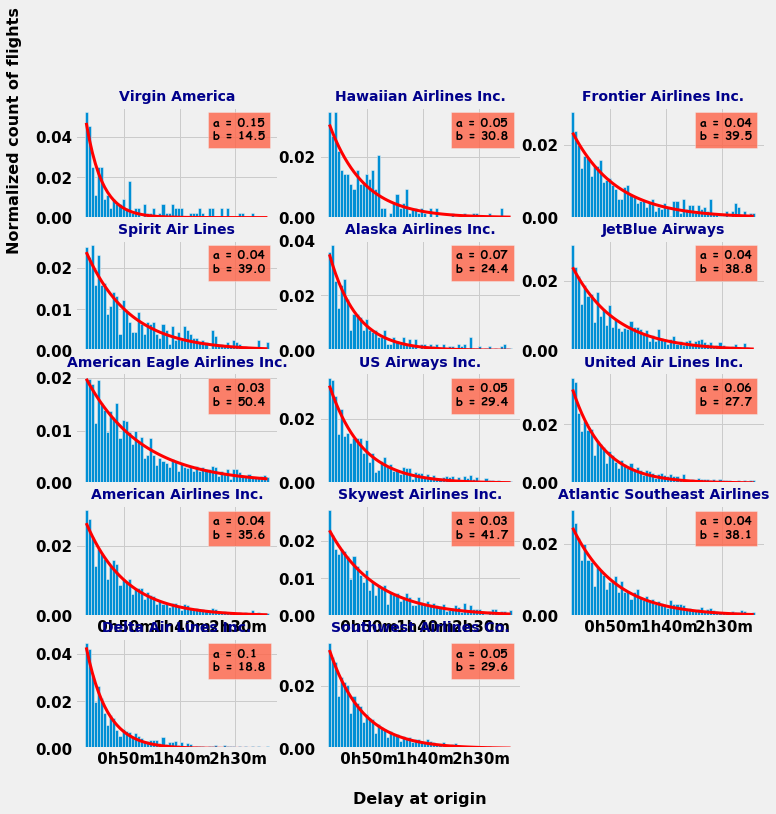

In [53]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()